In [44]:
import pandas as pd
import pandas_market_calendars as mcal

In [ ]:
df = pd.read_csv('final.csv')

df["timestamp"] = pd.to_datetime(df["timestamp"])

df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")

# Create NYSE trading calendar
nyse = mcal.get_calendar("NYSE")
df = df.set_index("timestamp")
# Generate valid trading days in your date range
schedule = nyse.schedule(start_date=df.index.min().date(), end_date=df.index.max().date())

# Get the list of valid trading days
valid_days = schedule.index.tz_localize("America/New_York")

is_trading_day = df.index.normalize().isin(valid_days)
is_trading_hours = (df.index.time >= pd.to_datetime("09:30").time()) & \
                   (df.index.time <= pd.to_datetime("16:00").time())

df['market_status'] = None

df.loc[is_trading_day, 'market_status'] = 'After Hours'

df.loc[is_trading_day & is_trading_hours, 'market_status'] = 'Trading'

df['market_status'].value_counts()



In [140]:
df[df['market_status'] == 'Trading']

df['return'] = df['close'].diff(1)

df.head()

df.to_csv('final.csv')

In [47]:
volatility_by_status = df.groupby('market_status')['return'].std()
print(volatility_by_status)

market_status
After Hours    0.123991
Trading        0.048925
Name: return, dtype: float64


This result clearly and numerically demonstrates that the volatility (as measured by the standard deviation of returns) is significantly higher during the After-Hours session compared to the standard Trading session. This is expected because lower liquidity and wider bid-ask spreads in after-hours trading lead to larger price swings.

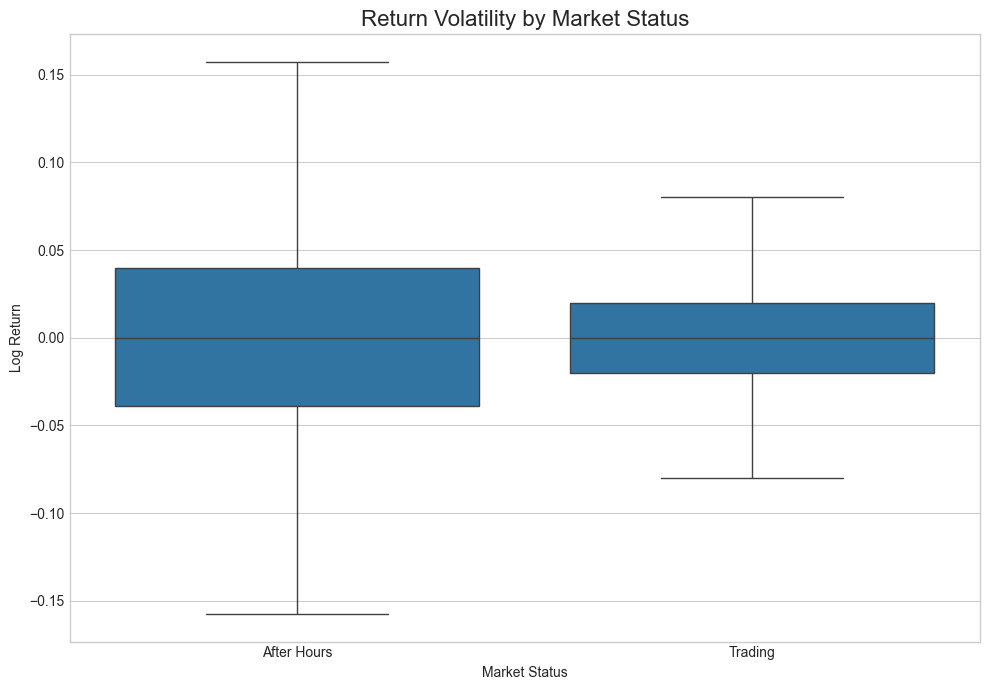

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(
    x='market_status',
    y='return',
    data=df,
    ax=ax,
    showfliers=False # Hides extreme outliers for a cleaner view
)

ax.set_title('Return Volatility by Market Status', fontsize=16)
ax.set_xlabel('Market Status')
ax.set_ylabel('Log Return')

# Optional: Zoom in on the y-axis to better see the boxes# Adjust these limits as needed

plt.tight_layout()
plt.show()


In [49]:
import numpy as np

after_hours_mins = 365 * 24 * 60 - 252 * 390

trading_mins = 252 * 390

annualization_factors = {
    'Trading': np.sqrt(trading_mins),         # Trading minutes in a year
    'After Hours': np.sqrt(after_hours_mins), # Total mins - trading mins
}




annualized_vol_by_status = volatility_by_status * pd.Series(annualization_factors)

print(annualized_vol_by_status)

annualized_vol_by_status.info

After Hours    81.052308
Trading        15.337752
dtype: float64


<bound method Series.info of After Hours    81.052308
Trading        15.337752
dtype: float64>

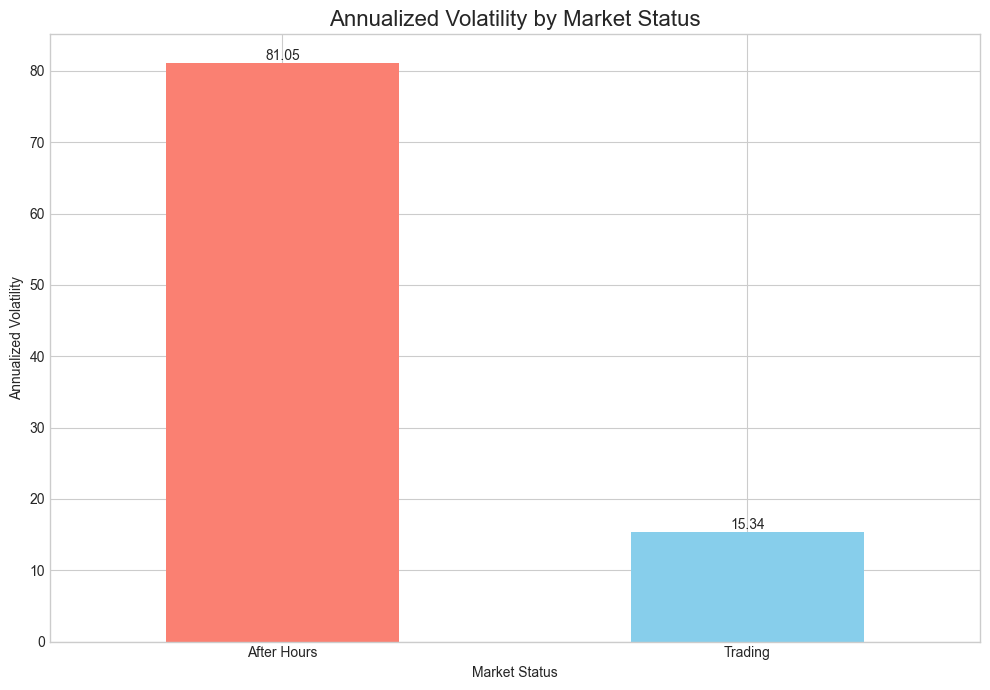

In [50]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Use the Series' .plot() method with kind='bar'
annualized_vol_by_status.plot(
    kind='bar',
    ax=ax,
    color=['salmon', 'skyblue'] # Assign colors to each bar
)

# Add labels and a title for clarity
ax.set_title('Annualized Volatility by Market Status', fontsize=16)
ax.set_ylabel('Annualized Volatility')
ax.set_xlabel('Market Status')

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0)

# Add data labels on top of each bar
for index, value in enumerate(annualized_vol_by_status):
    if value > 0: # Only label non-zero bars
        plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

An annualized volatility of 0.22 (or 22%) for the 'Trading' status means that the average minute during the market open over the last two years was characterized by a level of price fluctuation that would result in a 22% standard deviation in price over one year.

DATA TRANSFORMATION FOR FORECASTING/PREDICTIVE MODELLING


On a theoretical level and for low frequency data (e.g. daily), your formula seems right. However, since you are talking about one minute bars, things may get a little messy. There is a vast literature on this, and empirically, things are complicated due to market micro-structure noise. Namely, you need to do consider jumps, errors, periods of low volume, high volume periods (e.g. market opening of US markets when you look at European markets), and many other things. A nice overview on the topic with some references to literature is here:

we have seen through our analysis of the volatility that overnight and trading hour volatility and price action are different and to create our two models we need to ensure that our target variables for each are well defined. previously we have been disregarding our return calc but to be robust we employ a 

In [51]:
# intraday rolling vol is our target variable i,e (given past 5-30 mins of data what is vol 5 minutes from now)

import pandas as pd 
import pandas_market_calendars as mcal

df0= pd.read_csv('final.csv')


df0["timestamp"] = pd.to_datetime(df0["timestamp"])

df0["timestamp"] = df0["timestamp"].dt.tz_convert("America/New_York")

# Create NYSE trading calendar
nyse = mcal.get_calendar("NYSE")
df0 = df0.set_index("timestamp")
# Generate valid trading days in your date range
schedule = nyse.schedule(start_date=df0.index.min().date(), end_date=df0.index.max().date())

# Get the list of valid trading days
valid_days = schedule.index.tz_localize("America/New_York")

is_trading_day = df0.index.normalize().isin(valid_days)
is_trading_hours = (df0.index.time >= pd.to_datetime("09:30").time()) & \
                   (df0.index.time <= pd.to_datetime("16:00").time())

df0['market_status'] = None

df0.loc[is_trading_day, 'market_status'] = 'After Hours'

df0.loc[is_trading_day & is_trading_hours, 'market_status'] = 'Trading'

df0['market_status'].value_counts()



market_status
Trading        193837
After Hours     51109
Name: count, dtype: int64

As a result, all data from Jan 3rd at 9:30 AM until Jan 4th at 9:29 AM is treated as one continuous block. The .groupby(session_date) operation then correctly calculates the minute-over-minute return within this block. The first entry of a new session (Jan 4th at 9:30 AM) has no prior data in its new group, so its return is correctly set to NaN

we now have intraday returns and after market returns

LETS START WITH AN END GOAL

- we *wish* to find a method that does a couple things
1. forecast intraday next 5 min vol based off past (1,5,10,15,20,25,.......,300) mins of closing prices
2. account for overnight action and behaviour without letting the large variance overpower the much stronger and consistent variance of intraday action
3. godspeed 



Log returns are continuously compounded returns, while normal returns are simple returns calculated as a percentage change. Log returns are mathematically additive over time and symmetric, making them better for modeling and comparing long-term investment performance. Normal returns are easier to calculate for a single period but can be misleading when compounded because they are not symmetric and their sum doesn't reflect the final value accurately. (CHECK QUANT TEXTBOOK FOR PROOF)

df.head()

In [52]:
df['return'] = np.log(df['close'] / df['close'].shift(1))
horizon = 5 # minutes
trading_days_per_year = 252
minutes_per_day = 390

annualization_factor = np.sqrt(trading_days_per_year * minutes_per_day / horizon)

df_trading = df[df['market_status'] == 'Trading'].copy()
df_trading['squared_return'] = df_trading['return'] **2

daily_rolling_sum = df_trading.groupby(df_trading.index.date)['squared_return'].rolling(window=horizon).sum().reset_index(level=0, drop=True)

df_trading[f'RVOL_{horizon}m'] = np.sqrt(daily_rolling_sum) * annualization_factor


df = df.join(df_trading[f'RVOL_{horizon}m'])



In [53]:
print(df.loc['2023-01-03 09:30:00':'2023-01-03 10:30:00', f'RVOL_{horizon}m'])

# Check an after-hours period. The values will be NaN.
print("\n--- After-Hours Verification ---")
print(df[df['market_status'] == 'After-Hours'][f'RVOL_{horizon}m'].head())

timestamp
2023-01-03 09:30:00-05:00         NaN
2023-01-03 09:31:00-05:00         NaN
2023-01-03 09:32:00-05:00         NaN
2023-01-03 09:33:00-05:00         NaN
2023-01-03 09:34:00-05:00    0.608186
                               ...   
2023-01-03 10:26:00-05:00    0.189052
2023-01-03 10:27:00-05:00    0.356799
2023-01-03 10:28:00-05:00    0.374423
2023-01-03 10:29:00-05:00    0.418187
2023-01-03 10:30:00-05:00    0.433898
Name: RVOL_5m, Length: 61, dtype: float64

--- After-Hours Verification ---
Series([], Name: RVOL_5m, dtype: float64)


In [54]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(df.loc['2023-01-03 04:25:00':'2023-01-04 10:40:00'][['close', 'return','market_status', f'RVOL_{horizon}m']])

,close,return,market_status,RVOL_5m
timestamp,,,,
2023-01-03 04:39:00-05:00,70.2600,-0.000285,After Hours,NaN
2023-01-03 04:59:00-05:00,70.1100,-0.002137,After Hours,NaN
2023-01-03 05:08:00-05:00,69.9000,-0.003000,After Hours,NaN
2023-01-03 05:11:00-05:00,69.8000,-0.001432,After Hours,NaN
2023-01-03 05:26:00-05:00,69.6000,-0.002869,After Hours,NaN
...,...,...,...,...
2023-01-04 10:36:00-05:00,64.7700,0.000927,Trading,0.247800
2023-01-04 10:37:00-05:00,64.7875,0.000270,Trading,0.249742
2023-01-04 10:38:00-05:00,64.8000,0.000193,Trading,0.242673


result of above:

we now have a vol calculating that looks at the past hour of squared log returns and calculates rolling volatility of a rolling overlapping window of 60 minutes

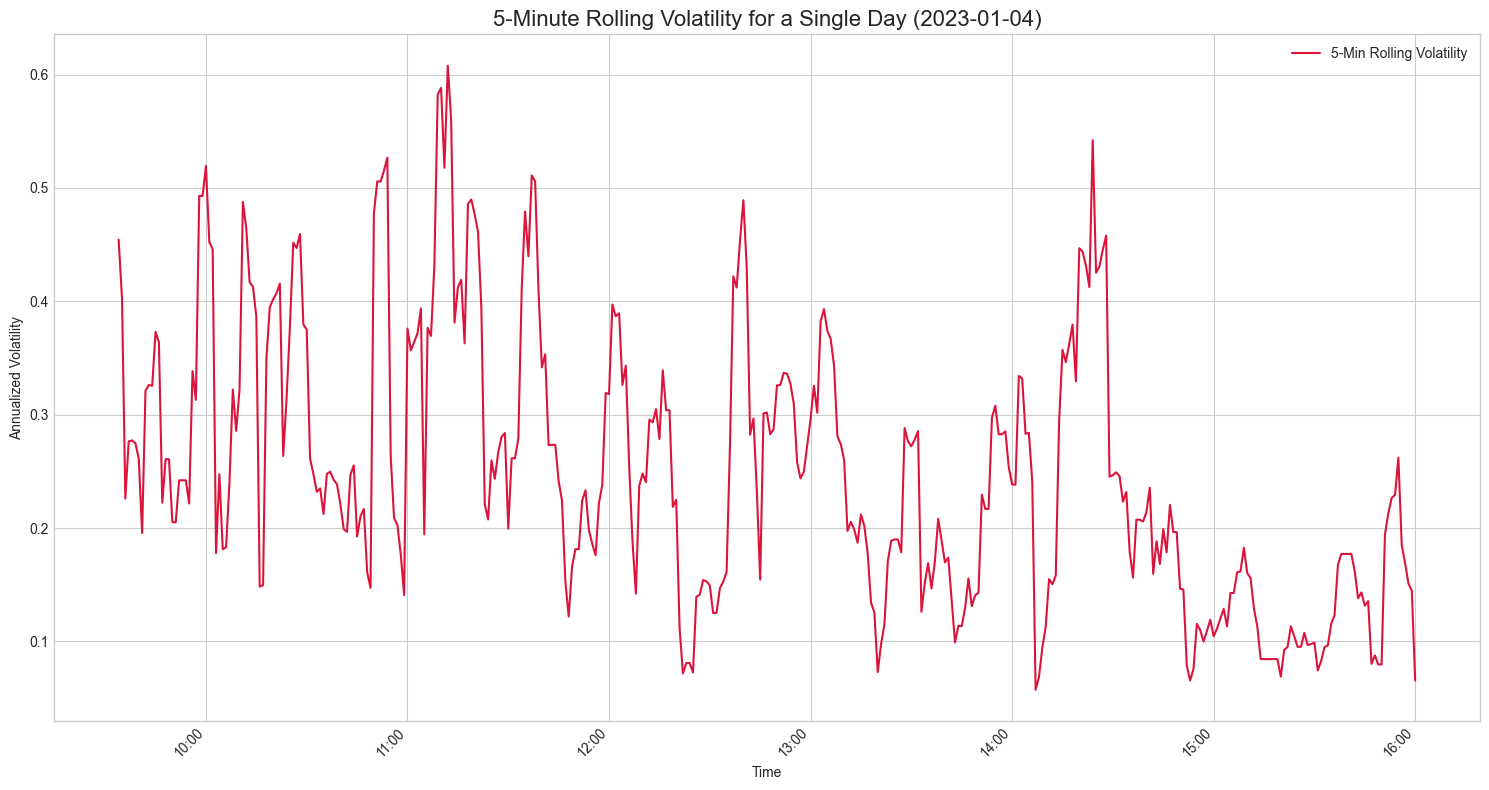

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

day_to_plot = '2023-01-04'
single_day_data = df_trading.loc[day_to_plot].copy()
single_day_data.index = single_day_data.index.tz_convert('America/New_York').tz_localize(None)






plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    single_day_data.index,
    single_day_data[f'RVOL_{horizon}m'],
    label=f'{horizon}-Min Rolling Volatility',
    color='crimson'
)

ax.set_title(f'{horizon}-Minute Rolling Volatility for a Single Day (2023-01-04)', fontsize=16)
ax.set_xlabel('Time')
ax.set_ylabel('Annualized Volatility')
ax.legend()

# Format the x-axis to show time as HH:MM
formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.tight_layout()
plt.show()

GARCH(1,1) MODEL

$$\sigma_{t}^{2}=\omega+\alpha_{1}\epsilon_{t-1}^{2}+\beta_{1}\sigma_{t-1}^{2}$$

where:$\sigma_{t}^{2}$ is the conditional variance at time $t$.$ \\
\omega$, $\alpha_{1}$, and $\beta_{1}$ are the model's parameters.$\epsilon_{t-1}^{2}$ \\ 
is the squared innovation (shock) from the previous period.$ \\
\sigma_{t-1}^{2}$ is the conditional variance from the previous period.\

note that in eda.ipynb we saw that the autocorrelation and partial autocorrelation graphs showed significant correlation at lag 1 and dropped off significantly after. 

In [153]:
from arch import arch_model 
from math import exp

df_trading['return_scaled'] = (df_trading['return']) * 1e05

split_index = int(len(df_trading) * 0.7)

train = df_trading.iloc[:split_index]
test = df_trading.iloc[split_index:]

garch_model = arch_model(train['return_scaled'], vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit()

print(garch_model_fit)
 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1190319.5416411632
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1164955.324055914
Iteration:      3,   Func. Count:     21,   Neg. LLF: 751471.4625874897
Iteration:      4,   Func. Count:     27,   Neg. LLF: 751733.2698336435
Iteration:      5,   Func. Count:     33,   Neg. LLF: 863909.9344924738
Iteration:      6,   Func. Count:     41,   Neg. LLF: 751295.3984648376
Iteration:      7,   Func. Count:     46,   Neg. LLF: 751284.119880652
Iteration:      8,   Func. Count:     52,   Neg. LLF: 751240.2403058937
Iteration:      9,   Func. Count:     57,   Neg. LLF: 751240.1608578585
Iteration:     10,   Func. Count:     62,   Neg. LLF: 751240.1605945344
Iteration:     11,   Func. Count:     67,   Neg. LLF: 751240.1690625872
Iteration:     12,   Func. Count:     75,   Neg. LLF: 751240.1605844093
Iteration:     13,   Func. Count:     80,   Neg. LLF: 751240.1605837601
Optimization terminated successfully    (Exit mode 0)
          

In [142]:
garch_model_fit.params()

TypeError: 'Series' object is not callable

In [ ]:
rolling_predictions = []
test_size = len(test)
return_data = df_trading['return_scaled']


for i in range(test_size):
    current_data =  return_data.iloc[:test_size+i]

    temp_model = arch_model(current_data, vol='GARCH', p=1,q=1)

    forecast = temp_model.forecast(
        params=garch_model_fit.params,
        horizon=1,
        start=current_data.index[-1],
        reindex=False
    )

    rolling_predictions.append(forecast.variance.iloc[-1,0])



In [163]:
test.loc[:,'vol_forecast'] = np.sqrt(rolling_predictions)
rmse = np.sqrt(np.mean( (test['vol_forecast'] - test['RVOL_5m'])**2))

qlike = np.mean(np.log(test['vol_forecast'] + (test['RVOL_5m']/test['vol_forecast'])))

print(f"rmse: {rmse} \n qlike: {qlike}")

benchmark_rmse = np.sqrt(np.mean( (test['RVOL_5m'] - test['RVOL_5m'].shift(1))**2))
benchmark_rmse

rmse: 0.6347152344601551 
 qlike: -0.03819661369229258


np.float64(0.052987289304320555)

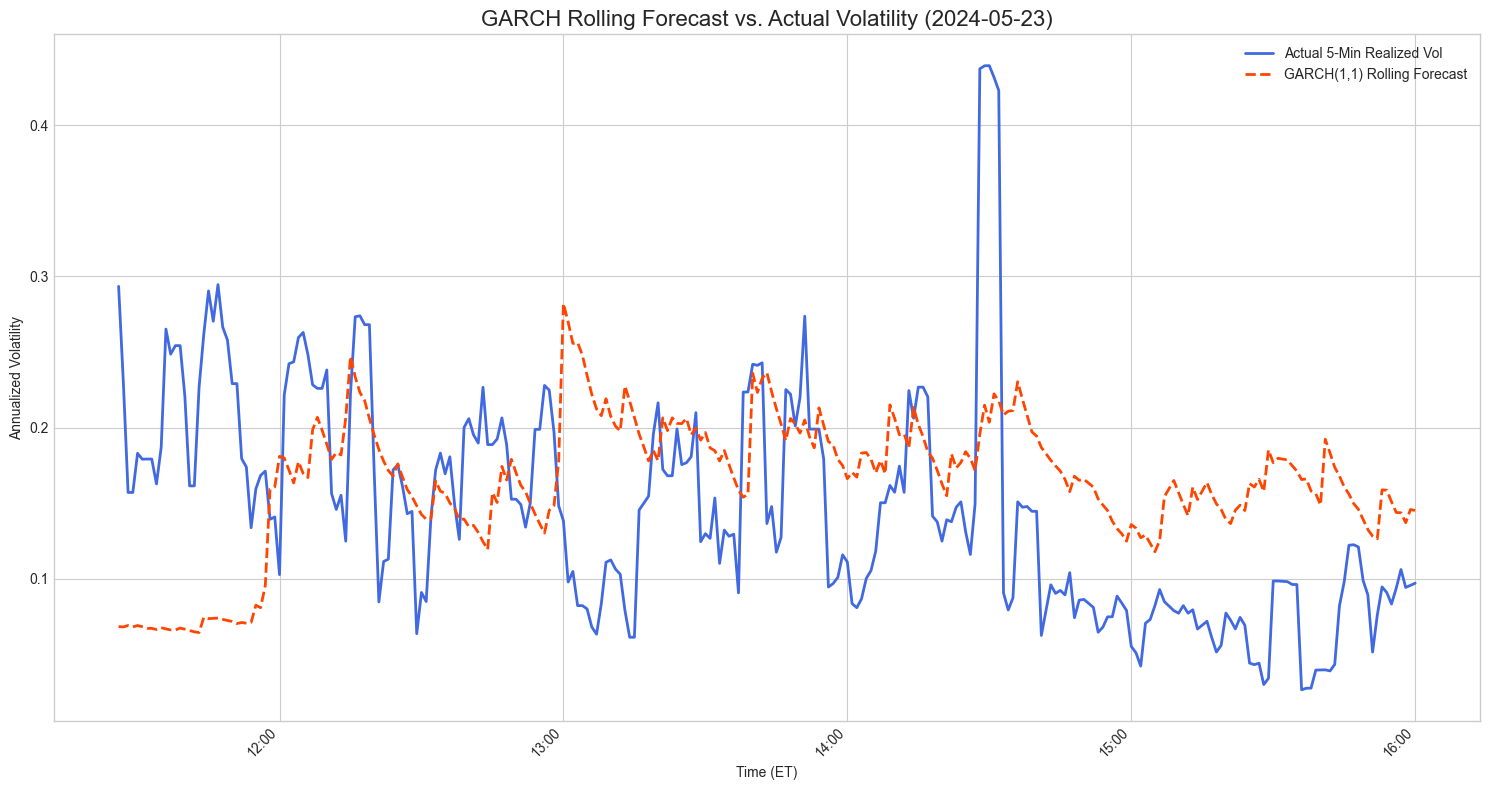

In [ ]:
test.loc[:,'garch_forecast_var'] = rolling_predictions

annualization_factor = np.sqrt(252*390)

test.loc[:,'garch_forecast_vol'] = np.sqrt(test['garch_forecast_var']/exp(3))
test.head()



day_to_plot = test.index.date[3]
plot_data = test.loc[str(day_to_plot)].copy()
plot_data.index = plot_data.index.tz_convert('America/New_York').tz_localize(None)
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the actual 5-minute realized volatility
ax.plot(
    plot_data.index,
    plot_data['RVOL_5m'],
    label='Actual 5-Min Realized Vol',
    color='royalblue',
    linewidth=2
)

# Plot the GARCH one-step-ahead forecast
ax.plot(
    plot_data.index,
    plot_data['garch_forecast_vol'],
    label='GARCH(1,1) Rolling Forecast',
    color='orangered',
    linestyle='--',
    linewidth=2
)

# --- 4. Format the Plot ---
ax.set_title(f'GARCH Rolling Forecast vs. Actual Volatility ({day_to_plot})', fontsize=16)
ax.set_xlabel('Time (ET)')
ax.set_ylabel('Annualized Volatility')
ax.legend()

formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.tight_layout()
plt.show()

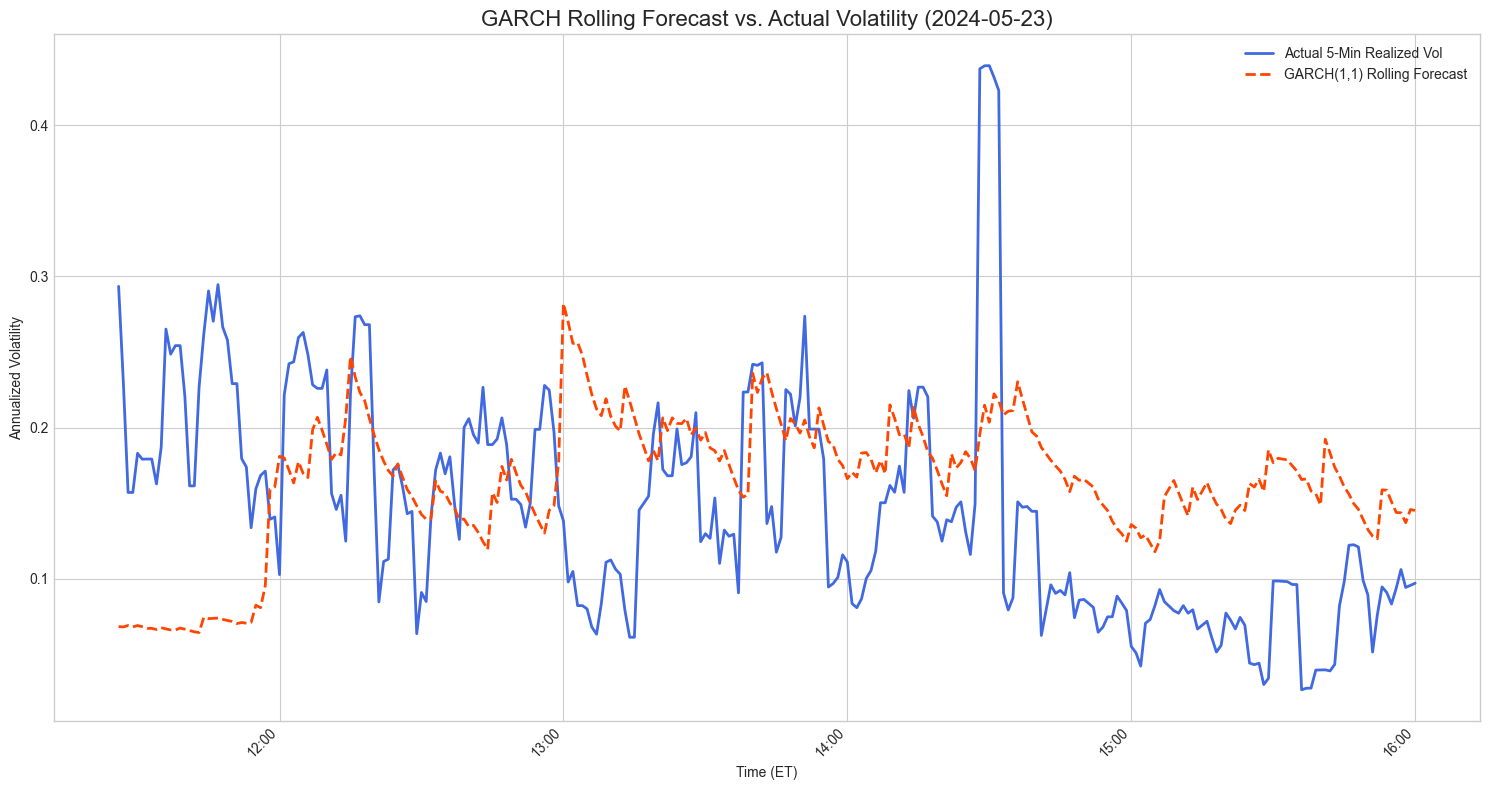

In [136]:
day_to_plot = test.index.date[0]
plot_data = test.loc[str(day_to_plot)].copy()
plot_data.index = plot_data.index.tz_convert('America/New_York').tz_localize(None)
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the actual 5-minute realized volatility
ax.plot(
    plot_data.index,
    plot_data['RVOL_5m'],
    label='Actual 5-Min Realized Vol',
    color='royalblue',
    linewidth=2
)

# Plot the GARCH one-step-ahead forecast
ax.plot(
    plot_data.index,
    plot_data['garch_forecast_vol'],
    label='GARCH(1,1) Rolling Forecast',
    color='orangered',
    linestyle='--',
    linewidth=2
)

# --- 4. Format the Plot ---
ax.set_title(f'GARCH Rolling Forecast vs. Actual Volatility ({day_to_plot})', fontsize=16)
ax.set_xlabel('Time (ET)')
ax.set_ylabel('Annualized Volatility')
ax.legend()

formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.tight_layout()
plt.show()